In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from time import time

In [2]:
def sigmoid(z):
    """Numerically stable sigmoid function."""
    z = np.clip(z, -500, 500)  # Limit z to avoid overflow
    return np.where(z >= 0,
                    1 / (1 + np.exp(-z)),
                    np.exp(z) / (1 + np.exp(z)))

In [3]:
def cross_entropy(y, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

In [4]:
def compute_gradients(X, y, y_pred):
    diff = y_pred - y
    return np.dot(X.T, diff) / len(y)

In [5]:
def initialize_weights(size):
    std_dev = np.sqrt(2 / (size + 1))
    return np.random.randn(size) * std_dev

In [6]:
class LogisticRegression:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs

    def fit(self, X_train, y_train):
        self.weights = initialize_weights(X_train.shape[1])
        self.losses = []

        for _ in range(self.epochs):
            y_pred = sigmoid(np.dot(X_train, self.weights))
            loss = cross_entropy(y_train, y_pred)
            self.losses.append(loss)

            gradients = compute_gradients(X_train, y_train, y_pred)
            self.weights -= self.lr * gradients

    def predict_probabilities(self, X):
        return sigmoid(np.dot(X, self.weights))
        
    def predict(self, X, threshold=0.5):
        return self.predict_probabilities(X) >= threshold

In [7]:
df1 = pd.read_csv('../data/match_data.csv')
X1 = df1.drop(columns=['Date', 'Team1', 'Team2', 'Score'])
y1 = df1['Score']
ds1_name = "match_data"
best_lr1 = 0.01
best_epochs1 = 3000

df2 = pd.read_csv('../data/cleaned_rounds_data.csv')
df2 = df2.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
X2 = df2.drop(['round_winner'], axis=1)
y2 = df2['round_winner']
ds2_name = "rounds_data"
best_lr2 = 0.3
best_epochs2 = 3000

df3 = pd.read_csv('../data/cleaned_rounds_data_with_stats.csv')
df3 = df3.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
X3 = df3.drop(columns=['round_winner'])
y3 = df3['round_winner']
ds3_name = "rounds_data_with_stats"
best_lr3 = 0.01
best_epochs3 = 4500


datasets = [(X1, y1, ds1_name, best_lr1, best_epochs1), (X2, y2, ds2_name, best_lr2, best_epochs2), (X3, y3, ds3_name, best_lr3, best_epochs3)]

Dataset: match_data with best_lr=0.01 and best_epochs=3000
Time to fit and predict: 2.425733804702759 seconds
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       378
           1       0.61      0.61      0.61       389

    accuracy                           0.61       767
   macro avg       0.61      0.61      0.61       767
weighted avg       0.61      0.61      0.61       767

                 Predicted Negative  Predicted Positive
Actual Negative                 226                 152
Actual Positive                 150                 239
ROC AUC: 0.6408441125664776
Dataset: rounds_data with best_lr=0.3 and best_epochs=3000
Time to fit and predict: 9.825947046279907 seconds
              precision    recall  f1-score   support

           0       0.75      0.72      0.74      1722
           1       0.74      0.77      0.76      1784

    accuracy                           0.75      3506
   macro avg       0.75      0.75      

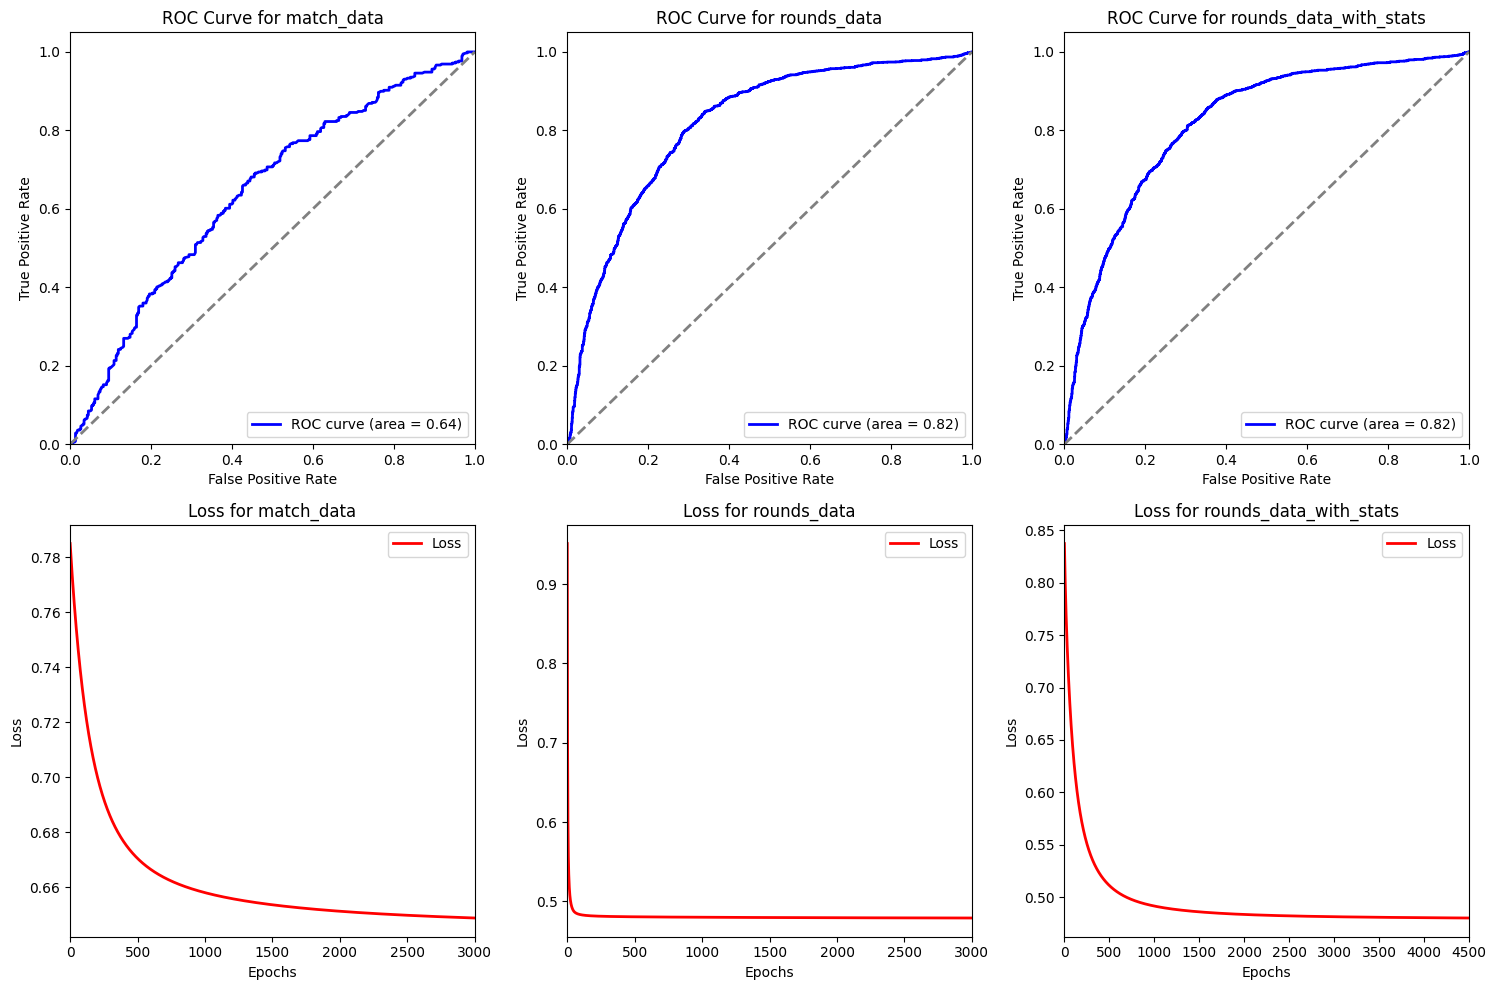

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for idx, (X, y, ds_name, best_lr, best_epochs) in enumerate(datasets):
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    model = LogisticRegression(lr=best_lr, epochs=best_epochs)
    
    start_time = time()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probs = model.predict_probabilities(X_test)

    print(f"Dataset: {ds_name} with best_lr={best_lr} and best_epochs={best_epochs}")
    print(f"Time to fit and predict: {time() - start_time} seconds")

    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'],
                                columns=['Predicted Negative', 'Predicted Positive'])
    print(conf_matrix_df)
    print(f"ROC AUC: {roc_auc_score(y_test, y_probs)}")
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    
    axs[0, idx].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_score(y_test, y_probs):.2f})')
    axs[0, idx].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    axs[0, idx].set_xlim([0.0, 1.0])
    axs[0, idx].set_ylim([0.0, 1.05])
    axs[0, idx].set_xlabel('False Positive Rate')
    axs[0, idx].set_ylabel('True Positive Rate')
    axs[0, idx].set_title(f'ROC Curve for {ds_name}')
    axs[0, idx].legend(loc='lower right')

    axs[1, idx].plot(range(best_epochs), model.losses, color='red', lw=2, label='Loss')
    axs[1, idx].set_xlim([0, best_epochs])
    axs[1, idx].set_xlabel('Epochs')
    axs[1, idx].set_ylabel('Loss')
    axs[1, idx].set_title(f'Loss for {ds_name}')
    axs[1, idx].legend(loc='upper right')
    
plt.tight_layout()
plt.show()